### Resources

- https://www.kaggle.com/nvhbk16k53/simple-rnn-with-keras


In [70]:
#import os; os.environ["OMP_NUM_THREADS"] = "4"

#modeling
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import keras
import keras.backend as K

#visualization
import matplotlib.pyplot as plt
import seaborn as sns
from jupyterthemes import jtplot
jtplot.style()

#APIs
import spotipy

## Read In All Data

In [71]:
features = pd.read_csv('data/song_features.csv', index_col=0)
users = pd.read_csv('data/user_playlists.csv', index_col=0)
songs = pd.read_csv('data/all_song_ids.csv', index_col=0)

/anaconda3/lib/python3.6/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [72]:
print(users.columns,'\n',songs.columns,'\n',features.columns)

Index(['user_id', 'artist', 'trackname', 'playlistname', 'user_playlistname',
       'playlist_size', 'playlist_position', 'playlist_null_count',
       'search_string'],
      dtype='object') 
 Index(['search_string', 'track_id'], dtype='object') 
 Index(['acousticness', 'analysis_url', 'danceability', 'duration_ms', 'energy',
       'id', 'instrumentalness', 'key', 'liveness', 'loudness', 'mode',
       'speechiness', 'tempo', 'time_signature', 'track_href', 'type', 'uri',
       'valence'],
      dtype='object')


In [73]:
df = pd.merge(users,songs,on='search_string').merge(features,left_on='track_id',right_on='id')

In [74]:
df.columns

Index(['user_id', 'artist', 'trackname', 'playlistname', 'user_playlistname',
       'playlist_size', 'playlist_position', 'playlist_null_count',
       'search_string', 'track_id', 'acousticness', 'analysis_url',
       'danceability', 'duration_ms', 'energy', 'id', 'instrumentalness',
       'key', 'liveness', 'loudness', 'mode', 'speechiness', 'tempo',
       'time_signature', 'track_href', 'type', 'uri', 'valence'],
      dtype='object')

## Re-Shape for modeling and analysis

In [75]:
cols = [
    'user_playlistname',
    'playlist_size',
    'playlist_position',
    'track_id',
    'tempo',
    'time_signature',
    'key',
    'mode',
]
abstractness = [
    #all the abstractness
    'acousticness',
    'danceability',
    'energy',
    'instrumentalness',
    'liveness',
    'loudness',
    'speechiness',
    'valence',
]

In [76]:
df = df[cols+abstractness]

In [77]:
df.drop_duplicates(inplace=True)

In [78]:
df.head()

,user_playlistname,playlist_size,playlist_position,track_id,tempo,time_signature,key,mode,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,valence
0,9cc0cfd4d7d7885102480dd99e7a90d6--IOW 2012,37.0,0,1KlDcHrlDPUJJPmMup3tUp,121.967,4.0,0,1,0.335,0.8,0.559,0.0,0.148,-7.11,0.116,0.788
8,650c4d63a819dbb77cc15a87f407039a--Sixty. One.,31.0,1,1KlDcHrlDPUJJPmMup3tUp,121.967,4.0,0,1,0.335,0.8,0.559,0.0,0.148,-7.11,0.116,0.788
16,29320fd2d36575b40d21b623adcf12b2--December 2013,17.0,0,1KlDcHrlDPUJJPmMup3tUp,121.967,4.0,0,1,0.335,0.8,0.559,0.0,0.148,-7.11,0.116,0.788
24,6fd8cee0e5c7241a5f963e727781c23f--Liked from R...,13.0,0,1KlDcHrlDPUJJPmMup3tUp,121.967,4.0,0,1,0.335,0.8,0.559,0.0,0.148,-7.11,0.116,0.788
32,7d44e6f576d82f175bd327bf48749dc0--~,21.0,0,1KlDcHrlDPUJJPmMup3tUp,121.967,4.0,0,1,0.335,0.8,0.559,0.0,0.148,-7.11,0.116,0.788


In [79]:
df.track_id.nunique()

699126

## Quick EDA

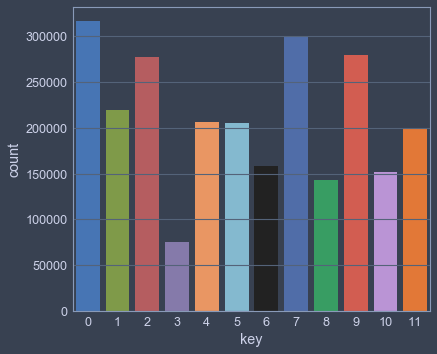

In [80]:
#key - root note
sns.countplot(df.key)

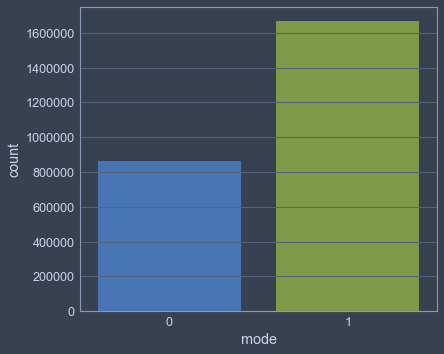

In [81]:
#mode - Major is 1, Minor is 0
sns.countplot(df['mode'])

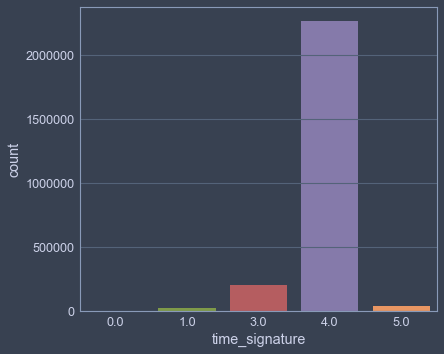

In [101]:
sns.countplot(df['time_signature'])

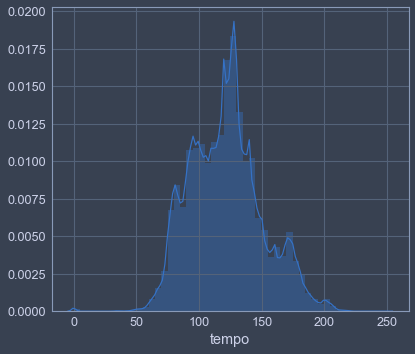

In [82]:
sns.distplot(df['tempo'])

#### Abstract Features

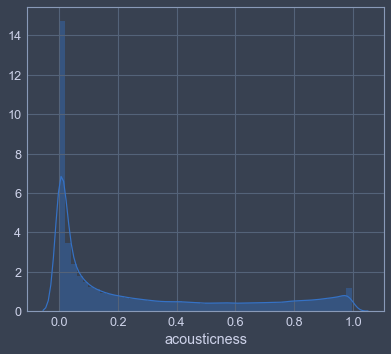

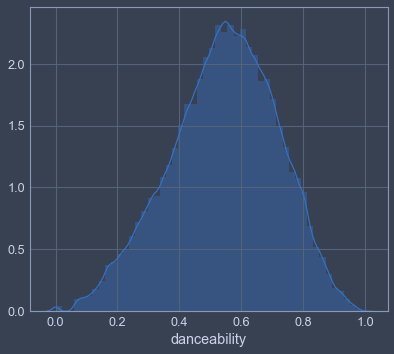

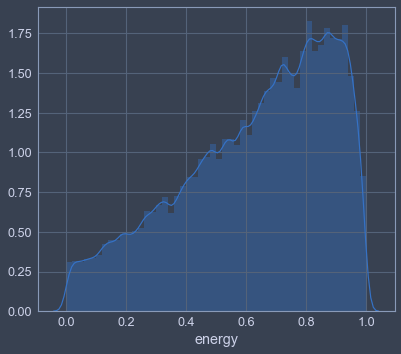

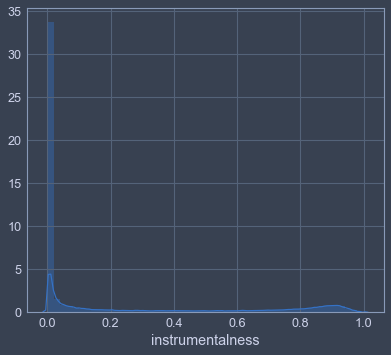

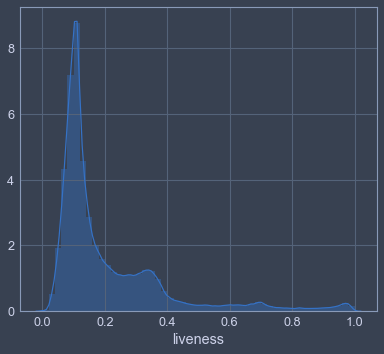

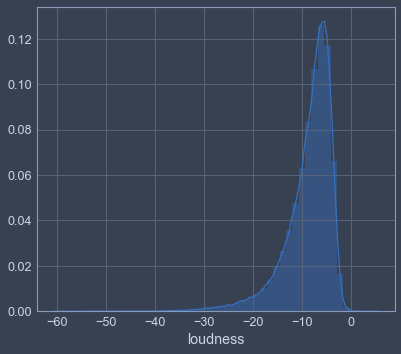

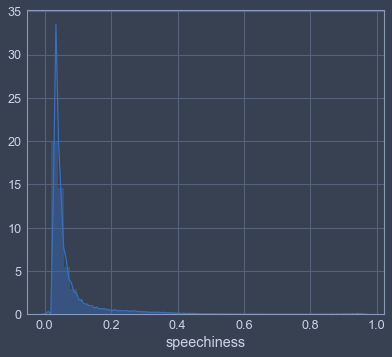

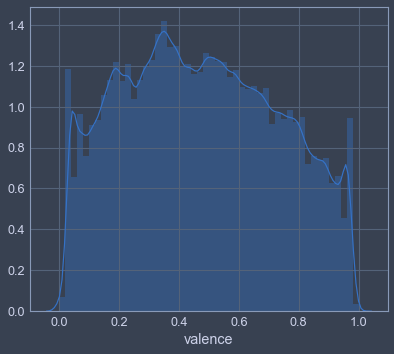

In [83]:
for att in abstractness:
    sns.distplot(df[att].dropna())
    plt.show() 

## Final Cleaning

In [84]:
df.head() 

,user_playlistname,playlist_size,playlist_position,track_id,tempo,time_signature,key,mode,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,valence
0,9cc0cfd4d7d7885102480dd99e7a90d6--IOW 2012,37.0,0,1KlDcHrlDPUJJPmMup3tUp,121.967,4.0,0,1,0.335,0.8,0.559,0.0,0.148,-7.11,0.116,0.788
8,650c4d63a819dbb77cc15a87f407039a--Sixty. One.,31.0,1,1KlDcHrlDPUJJPmMup3tUp,121.967,4.0,0,1,0.335,0.8,0.559,0.0,0.148,-7.11,0.116,0.788
16,29320fd2d36575b40d21b623adcf12b2--December 2013,17.0,0,1KlDcHrlDPUJJPmMup3tUp,121.967,4.0,0,1,0.335,0.8,0.559,0.0,0.148,-7.11,0.116,0.788
24,6fd8cee0e5c7241a5f963e727781c23f--Liked from R...,13.0,0,1KlDcHrlDPUJJPmMup3tUp,121.967,4.0,0,1,0.335,0.8,0.559,0.0,0.148,-7.11,0.116,0.788
32,7d44e6f576d82f175bd327bf48749dc0--~,21.0,0,1KlDcHrlDPUJJPmMup3tUp,121.967,4.0,0,1,0.335,0.8,0.559,0.0,0.148,-7.11,0.116,0.788


In [85]:
df.sort_values(by = ['user_playlistname','playlist_position'],inplace=True)
df.reset_index(drop=True,inplace=True)

In [86]:
df.head() 

,user_playlistname,playlist_size,playlist_position,track_id,tempo,time_signature,key,mode,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,valence
0,000b0f32b5739f052b9d40fcc5c41079--Contacta,22.0,2,7exdcu9SmgcrZ7hW9ZdcYo,94.948,4.0,6,1,0.1420,0.336,0.6470,0.00616,0.8260,-7.718,0.0390,0.207
1,000b0f32b5739f052b9d40fcc5c41079--Contacta,22.0,4,74s8tx6zJ8Cv7wwmbdHpzs,111.290,4.0,11,1,0.0144,0.393,0.8830,0.00000,0.9210,-7.131,0.0842,0.363
2,000b0f32b5739f052b9d40fcc5c41079--Contacta,22.0,5,4xy4PLTOPsa4ZG70FMNleU,116.178,4.0,4,1,0.9440,0.570,0.0453,0.00000,0.0970,-14.302,0.0614,0.488
3,000b0f32b5739f052b9d40fcc5c41079--Contacta,22.0,7,4otzLquDO3IQM8f8pybbfP,67.133,4.0,6,1,0.7570,0.470,0.4360,0.00000,0.0798,-13.103,0.0369,0.583
4,000b0f32b5739f052b9d40fcc5c41079--Contacta,22.0,8,1yUNP810gdYDu61k2izbLB,105.947,4.0,0,1,0.0700,0.619,0.8360,0.00752,0.1250,-6.140,0.0418,0.347


In [100]:
df.set_index(['user_playlistname','playlist_position'])

playlist_size  \
user_playlistname                                  playlist_position                  
000b0f32b5739f052b9d40fcc5c41079--Contacta         2                           22.0   
                                                   4                           22.0   
                                                   5                           22.0   
                                                   7                           22.0   
                                                   8                           22.0   
                                                   9                           22.0   
                                                   12                          22.0   
                                                   14                          22.0   
                                                   15                          22.0   
                                                   16                          22.0   
                                                   17                          22.0   
                                                   19                          22.0   
                                                   21                          22.0   
000b0f32b5739f052b9d40fcc5c41079--Gospel           0                           42.0   
                                                   1                           42.0   
                                                   2                           42.0   
                                                   3                           42.0   
                                                   4                           42.0   
                                                   5                           42.0   
                                                   6                           42.0   
                                                   7                           42.0   
                                                   8                           42.0   
                                                   9                           42.0   
                                                   10                          42.0   
                                                   11                          42.0   
                                                   12                          42.0   
                                                   13                          42.0   
                                                   14                          42.0   
                                                   15                          42.0   
                                                   16                          42.0   
...                                                                             ...   
fff616055993498d6127f3f467cf9f2b--holidays         15                          20.0   
                                                   16                          20.0   
                                                   17                          20.0   
                                                   18                          20.0   
                                                   19                          20.0   
fff616055993498d6127f3f467cf9f2b--natural eleme... 0                           26.0   
                                                   1                           26.0   
                                                   2                           26.0   
                                                   3                           26.0   
                                                   4                           26.0   
                                                   5                           26.0   
                                                   6                           26.0   
                                                   7                           26.0   
                                                   8                